# Experiment Analysis

In [1]:
# Imports:

import os 
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

sys.path.append(os.path.join("..", "code"))
from utils import open_y_data

pd.set_option("display.max_colwidth", 500)

DIR = os.getcwd()
EXPERIMENT_DIR = os.path.join(os.path.dirname(DIR), "experiments")
if not os.path.exists(EXPERIMENT_DIR):
    os.mkdir(EXPERIMENT_DIR)
    
def experiment_path(name: str):
    return os.path.join(EXPERIMENT_DIR, name)

y = open_y_data()
y["date"] = y["date"].dt.date

In [2]:
experiment_list = os.listdir(EXPERIMENT_DIR)
experiment_dirs = list()
experiment_names = list()
for name in experiment_list:
    fp = experiment_path(name)
    if os.path.isdir(fp) and ("__trained_model" not in name) and ("." not in name):
        experiment_dirs.append(fp)
        experiment_names.append(name)

In [3]:
yamls = [f"{name}__metadata.yaml" for name in experiment_names]
metadata = list()
for yml in yamls:
    try:
        fp = experiment_path(yml)
        with open(fp, "r") as f:
            data = yaml.safe_load(f)
            metadata.append(data)
    except FileNotFoundError:
        continue
experiments = pd.DataFrame(metadata)
for time_col in [c for c in experiments.columns if "time" in c]:
    experiments[time_col] = pd.to_datetime(experiments[time_col], format="%Y_%m_%d__%H_%M_%S")

In [6]:
def combine_pred_and_truth(experiment_id: str, pred_type: str = "val"):
    experiment_data = experiments[experiments["id"] == experiment_id].iloc[0]
    fp = experiment_path(f"{experiment_id}__{pred_type}_pred.csv")
    df = pd.read_csv(fp, encoding="utf-8")
    df["gage"] = df["gage"].astype(str)
    df["date"] = pd.to_datetime(df["date"]).dt.date

    merged = pd.concat([y.set_index(["gage", "date"]), 
                        df.set_index(["gage", "date"])], axis=1)
    y_col = experiment_data["y_col"]
    pred_cols = [c for c in merged.columns if "y_day" in c]

    if y_col == "m3":
        pass
    # If predicted area-normalized values, convert back to actual value:
    elif y_col == "m3_per_area_km":
        for col in pred_cols:
            merged[col] = merged[col] * merged["area_km"]
    elif y_col == "m3_per_area_miles":
        for col in pred_cols:
            merged[col] = merged[col] * merged["area_miles"]
    elif y_col == "m3_per_area_m":
        for col in pred_cols:
            merged[col] = merged[col] * merged["area_m"]
    else:
        raise ValueError(f"Code not written for y_col: {y_col}")

    merged = merged.sort_index()

    # Shift the prediction columns to align with the true values:
    for col in pred_cols:
        n_days = int(col.replace("y_day_", ""))
        merged[f"{col}_aligned"] = merged[col].shift(n_days)

    subset = [c for c in merged.columns if "y_day_" in c]
    return merged.dropna(subset=subset, how="all")

In [7]:
merged = combine_pred_and_truth('f8804858-d98a-4207-8f0f-ef9707f1c7cd')

In [8]:
def plot_pred_vs_true(merged_df: pd.DataFrame, gage: str, days: list = (1, 7, 14)):
    n_rows = len(days)
    fig, axes = plt.subplots(n_rows, 1, figsize=(8, n_rows*4), dpi=200)
    plot_df = merged_df.reset_index().copy()
    plot_df = plot_df[plot_df["gage"] == gage].sort_values(by=["date"])
    for day, ax in zip(days, axes.flatten()):
        col_name = f"y_day_{day}_aligned"
        plot_df = plot_df.dropna(subset=[col_name])
        ax.plot(plot_df["date"].values, plot_df["m3"].values, color="b", label="ground truth")
        ax.plot(plot_df["date"].values, plot_df[col_name].values, color="r", label="prediction")
        ax.set_title(f"Gage {gage}: Discharge Predictions from {day} Day{'s' if day > 1 else ''} Prior")
        ax.legend()
        ax.set_ylabel("Discharge m3")
    return fig

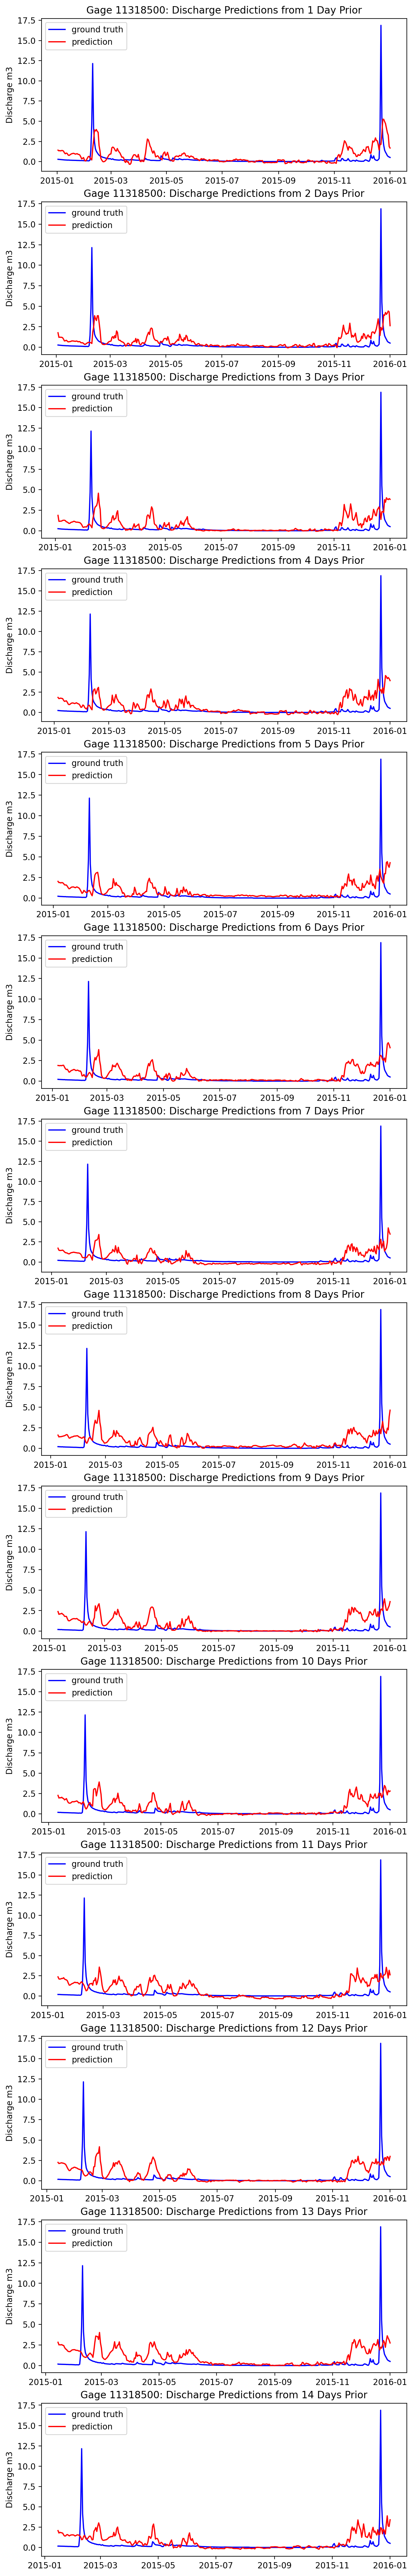

In [9]:
plot_pred_vs_true(merged, "11318500", days=list(range(1, 15, 1)))